In [2]:
import configparser
import Src.data.dmbioProtDataset as dmbiods
from Src.data.dmBioProtDatasetLoader import dmbioProtDatasetloader
from torch_geometric.data import Data
import Src.model.egnn_clean as eg
from Src.model.dmBioGNN import GNNModel
import torch
import numpy as np
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import egnn_training_v1 as et


In [3]:
pl.__version__

'2.4.0'

In [4]:
config_path = '/teamspace/studios/this_studio/DeepDive/Prot-DNA_experiments/test/testDatasetConfig.ini'
dataset_loader = dmbioProtDatasetloader(config_path)
train, val , test = dataset_loader.split_train_test_validation()
len(train.dataset),len(val.dataset),len(test.dataset)

Loading Dataset!


(400, 57, 114)

In [5]:
#Populate dataset
data = train.dataset[0]
data

Data(x=[63, 5461], edge_index=[2, 766], edge_attr=[766, 1], y=[63, 1], pos=[63, 3])

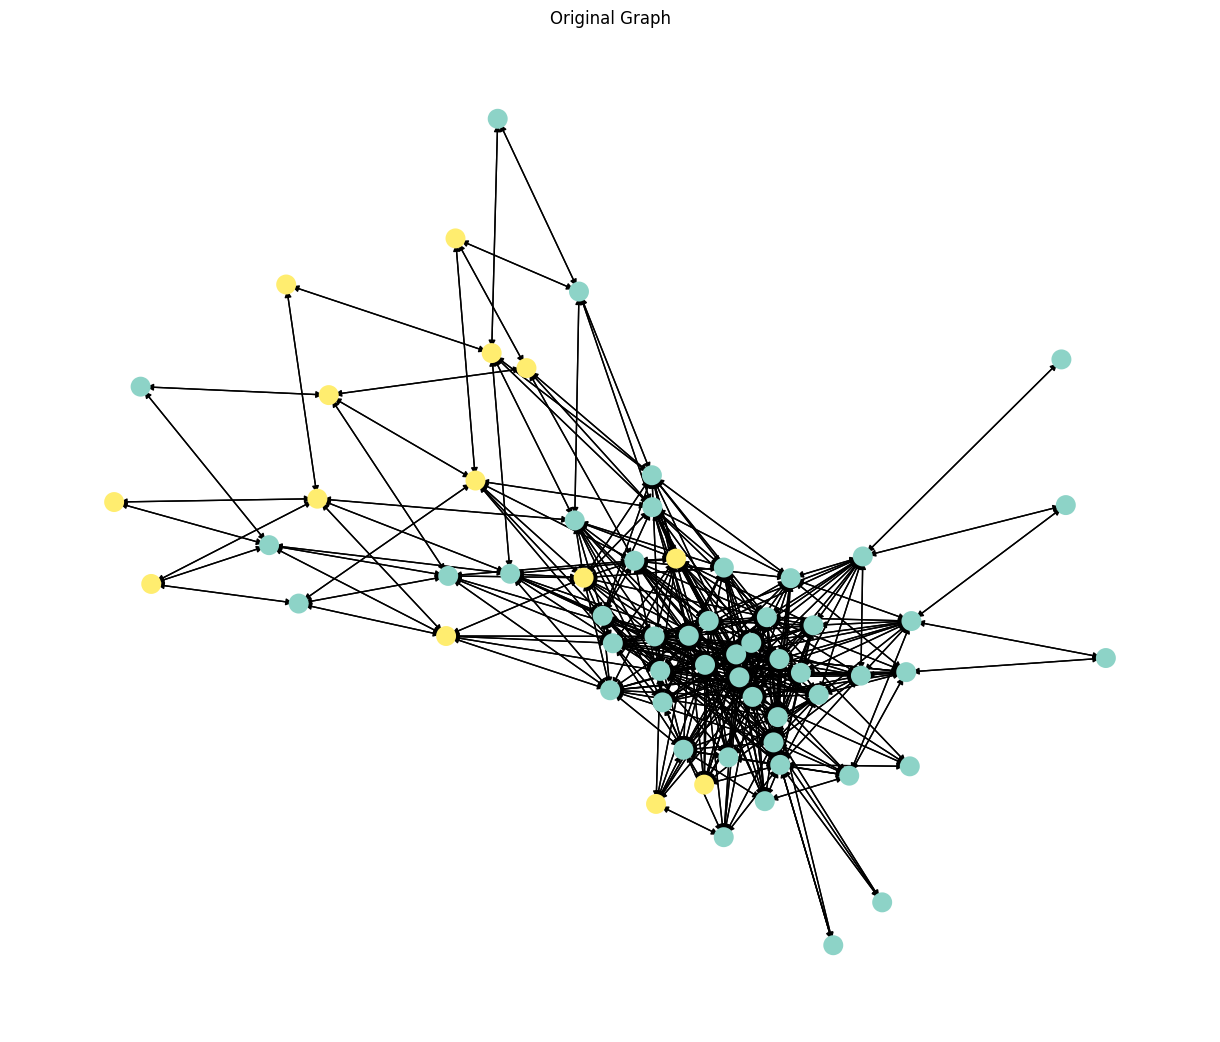

In [6]:
vis = to_networkx(data)
node_labels = data.y.numpy()
plt.figure(1,figsize=(12,10)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.title(f'Original Graph')
plt.show()

In [7]:
#test with egnn model
torch.manual_seed(1231)
egnn = eg.EGNN(in_node_nf=data.x.shape[1], hidden_nf=1028, out_node_nf=1, in_edge_nf=1)
criterion = torch.nn.BCELoss()
h, x = egnn(data.x, data.pos, data.edge_index, data.edge_attr)
pred = torch.nn.Sigmoid()(h)
l1_loss = criterion(pred, data.y)
print(f'loss:{l1_loss.item()}')

loss:0.6366453170776367


In [8]:
#evaluation
pred = pred.squeeze()
pred = torch.tensor([0 if each<0.5 else 1 for each in pred], dtype=torch.int32)
y_int = data.y.to(torch.int64)
y_int = y_int.squeeze()
t_p = ((pred == 1) & (y_int == 1)).sum()
t_n = ((pred == 0) & (y_int == 0)).sum()
actual_p = (y_int == 1).sum()
t_p, t_n, actual_p


(tensor(4), tensor(43), tensor(14))

In [9]:
y_int, pred

(tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=torch.int32))

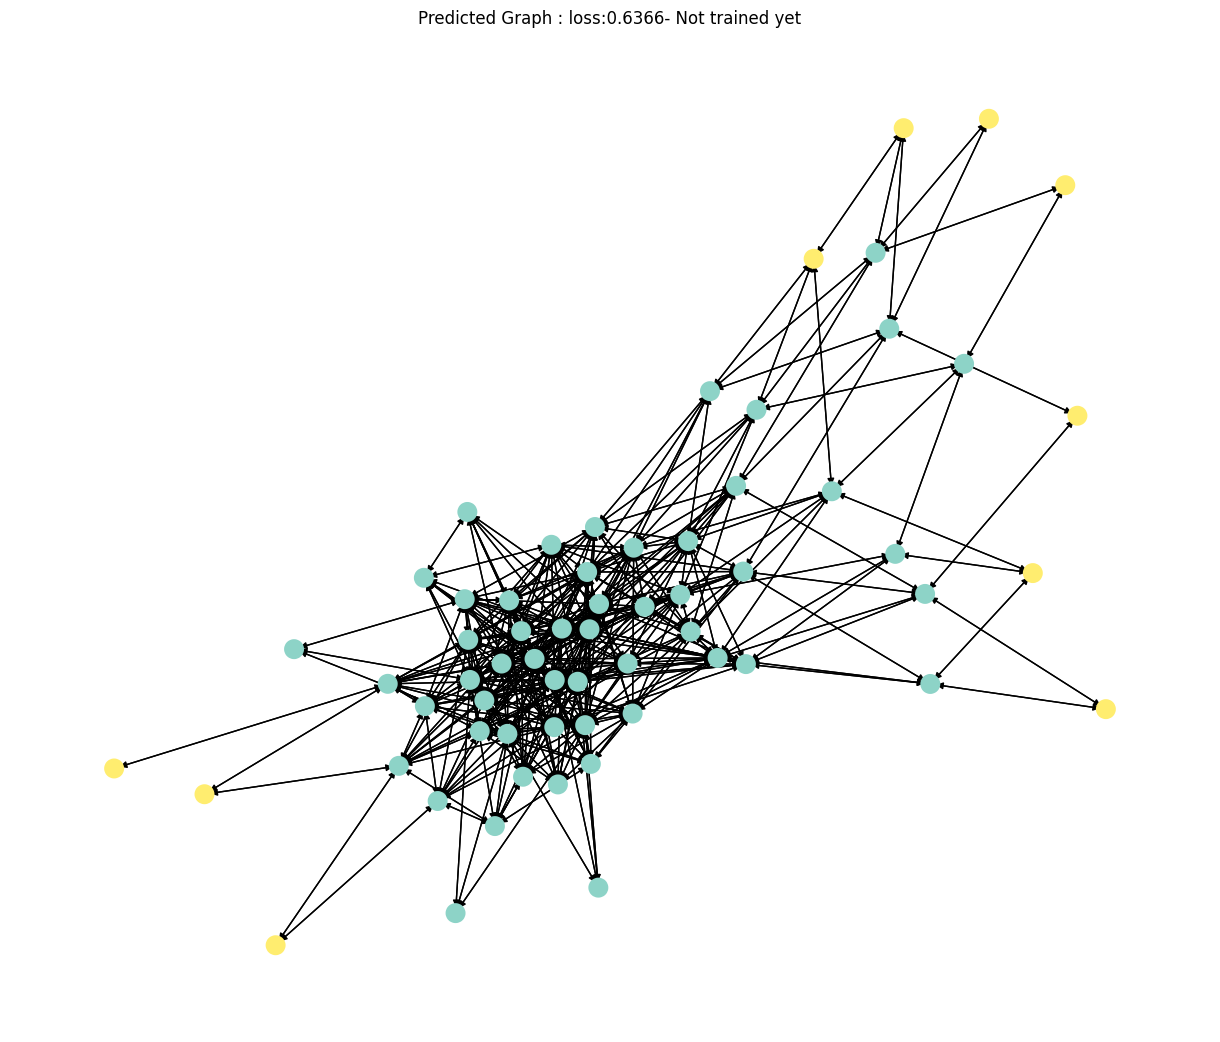

In [10]:
pred_y  = pred.unsqueeze(dim=1)
graph_pred = Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, pos=data.pos, y=pred_y)
vis = to_networkx(graph_pred)

node_labels = pred_y.numpy()


plt.figure(1,figsize=(12,10)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.title(f'Predicted Graph : loss:{l1_loss.item():.4f}- Not trained yet')
plt.show()

In [ ]:
#test with egnn model
torch.manual_seed(1232)
c_in = dataset_loader.num_features
hidden_layers = [2048, 1024 , 512]
gnnModel = GNNModel(c_in = c_in, c_hiddens= hidden_layers)
criterion = torch.nn.BCELoss()
y_hat = gnnModel(data.x, data.edge_index)
pred = torch.sigmoid(y_hat)
l1_loss = criterion(pred, data.y)
print(f'loss:{l1_loss.item()}')

loss:0.9053813219070435


In [ ]:
gnnModel.eval()

GNNModel(
  (layers): ModuleList(
    (0): GCNConv(5461, 2048)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): GCNConv(2048, 1024)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): GCNConv(1024, 512)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9): GCNConv(512, 1)
  )
)

In [ ]:
pred = (pred.squeeze()>=0.5).to(int)
y_int = data.y.to(torch.int64).squeeze()
pred, y_int

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [ ]:
t_p = ((pred == 1) & (y_int == 1)).sum()
t_n = ((pred == 0) & (y_int == 0)).sum()
f_n = ((pred == 0) & (y_int == 1)).sum()
f_p = ((pred == 1) & (y_int == 0)).sum()

t_p, f_n, f_p , t_p /(t_p+f_n+1e-8) , f_p / (f_p + t_n+1e-8) , t_p / (f_p + t_p+1e-8)

(tensor(14), tensor(0), tensor(49), tensor(1.), tensor(1.), tensor(0.2222))

In [11]:
import os
device_count = torch.cuda.device_count() - 1 if torch.cuda.is_available() else 0
device = torch.device(f'cuda:{device_count}') if torch.cuda.is_available() else torch.device('cpu')

chkptpath = '/teamspace/studios/this_studio/DeepDive/Prot-DNA_experiments/CheckPoint'
model_path = os.path.join(chkptpath,"ProtDNAAffinity_EGNN", "lightning_logs",f"version_0","checkpoints","EGNNModel.ckpt")
model = et.dmbioProtAffinityEGNN.load_from_checkpoint(model_path, fileLogger = None)
model.to(device)

dmbioProtAffinityEGNN(
  (model): EGNN(
    (embedding_in): Linear(in_features=5461, out_features=768, bias=True)
    (embedding_out): Linear(in_features=768, out_features=1, bias=True)
    (gcl_0): E_GCL(
      (edge_mlp): Sequential(
        (0): Linear(in_features=1538, out_features=768, bias=True)
        (1): SiLU()
        (2): Linear(in_features=768, out_features=768, bias=True)
        (3): SiLU()
      )
      (node_mlp): Sequential(
        (0): Linear(in_features=1536, out_features=768, bias=True)
        (1): SiLU()
        (2): Linear(in_features=768, out_features=768, bias=True)
      )
      (coord_mlp): Sequential(
        (0): Linear(in_features=768, out_features=768, bias=True)
        (1): SiLU()
        (2): Linear(in_features=768, out_features=1, bias=False)
      )
      (att_mlp): Sequential(
        (0): Linear(in_features=768, out_features=1, bias=True)
        (1): Sigmoid()
      )
    )
    (gcl_1): E_GCL(
      (edge_mlp): Sequential(
        (0): Linear(in

In [12]:
batch = test.dataset[0]
batch = batch.to(device)
batch

Data(x=[121, 5461], edge_index=[2, 2904], edge_attr=[2904, 1], y=[121, 1], pos=[121, 3])

In [13]:
x, edge_index, pos, edge_attr ,y = batch.x, batch.edge_index, batch.pos, batch.edge_attr, batch.y
h, x = model.model(x, pos, edge_index, edge_attr)

In [14]:
pred = torch.sigmoid(h)
pred = (pred.squeeze()>=0.5).to(int).to(device)
y_int = y.to(torch.int64).squeeze()

t_p = ((pred == 1) & (y_int == 1)).sum()
t_n = ((pred == 0) & (y_int == 0)).sum()
f_n = ((pred == 0) & (y_int == 1)).sum()
f_p = ((pred == 1) & (y_int == 0)).sum()

t_p, f_n, f_p , t_p /(t_p+f_n+1e-8) , f_p / (f_p + t_n+1e-8) , t_p / (f_p + t_p+1e-8)

(tensor(6),
 tensor(17),
 tensor(1),
 tensor(0.2609),
 tensor(0.0102),
 tensor(0.8571))

In [15]:
pred, y_int

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]))

In [16]:
from torch import tensor
from torchmetrics.classification import BinaryRecall
# target = tensor([0, 1, 0, 1, 0, 1])
# preds = tensor([0, 0, 1, 1, 0, 1])
metric = BinaryRecall()
metric(pred, y_int)

tensor(0.2609)